In [74]:
# installing dependencies
import mne
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [58]:
'''
Obtaining raw data from the BCICIV data
Data consists of mainly right and left hand motions
but also constitutes moments of no motion (baseline)
'''
raw = mne.io.read_raw_gdf('BCICIV_2a_gdf\A01T.gdf', preload=True)


Extracting EDF parameters from c:\Users\aliz0\OneDrive\Documents\GitHub\EEGTetris\ml\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


c:\Users\aliz0\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


In [59]:
# Obtaining all channel names 
channel_names = raw.info['ch_names']
#print(channel_names)

#Obtaining a subset of those channels
channels_to_keep = ['EEG-1', 'EEG-3', 'EEG-C3', 'EEG-C4', 'EEG-14', 'EEG-Pz', 'EEG-15']     # F3, F4, C3, C4, Pz, P3, P4

raw_subset = raw.copy().pick(channels_to_keep)

In [71]:
'''
order_to_class_id = {
    '1' : 'Idling Eyes Open',
    '2' : 'Idling Eyes Closed',
    '3' : 'Trial Start',
    '4' : 'Cue Left',
    '5' : 'Cue Right',
    '6' : 'Cue Foot',
    '7' : 'Cue Tongue', 
    '8' : 'Cue Unknown',
    '9' : 'Rejected Trial',
    '10': 'Eye Movements',
    '11': 'Next Run'
}

og_event_id = {
    '276'  : 'Idling Eyes Open',
    '277'  : 'Idling Eyes Closed',
    '768'  : 'Trial Start',
    '769'  : 'Cue Left',
    '770'  : 'Cue Right',
    '771'  : 'Cue Foot',
    '772'  : 'Cue Tongue', 
    '783'  : 'Cue Unknown',
    '1023' : 'Rejected Trial',
    '1072' : 'Eye Movements',
    '32766': 'Next Run'
}
'''


ordered_event_id = {
    '276'  : 1,
    '277'  : 2,
    '768'  : 3,
    '769'  : 4,
    '770'  : 5,
    '771'  : 6,
    '772'  : 7, 
    #'783'  : 8,
    '1023' : 9,
    '1072' : 10,
    '32766': 11
}

events, event_id = mne.events_from_annotations(raw_subset, event_id = ordered_event_id)
# events.shape, events[:10]

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


((603, 3),
 array([[    0,     0,    11],
        [    0,     0,     1],
        [29683,     0,    11],
        [29683,     0,     2],
        [49955,     0,    11],
        [49955,     0,    10],
        [91518,     0,    11],
        [91868,     0,     3],
        [92368,     0,     7],
        [93871,     0,     3]]))

In [87]:
events_df = pd.DataFrame(events, columns = ["sample_index", "prev_signal", "event_code"])
event_idx = events_df[events_df['event_code'] == 4]['sample_index']

In [98]:
def baseline_chunking(event_idx):
    baseline_data = []
    for idx in event_idx:
        channel_data = []
        for channel in data:
            channel_data.append(channel[idx-500:idx])
        baseline_data.append(channel_data)
    return baseline_data

In [104]:
def event_chunking(event_idx, offset=250):
    event_data = []
    for idx in event_idx:
        channel_data = []
        for channel in data:
            channel_data.append(channel[idx+offset:idx+offset+500])
        event_data.append(channel_data)
    return event_data

In [105]:
baseline_data = baseline_chunking(event_idx)
event_data = event_chunking(event_idx)

In [85]:
# Check for data shape
data = raw_subset.get_data()
type(data), data.shape

(numpy.ndarray, (7, 672528))

In [61]:
# filtering done here; bandpassing between 8 and 30 Hz
raw_subset_8_30 = raw_subset.copy().filter(8, 30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s finished


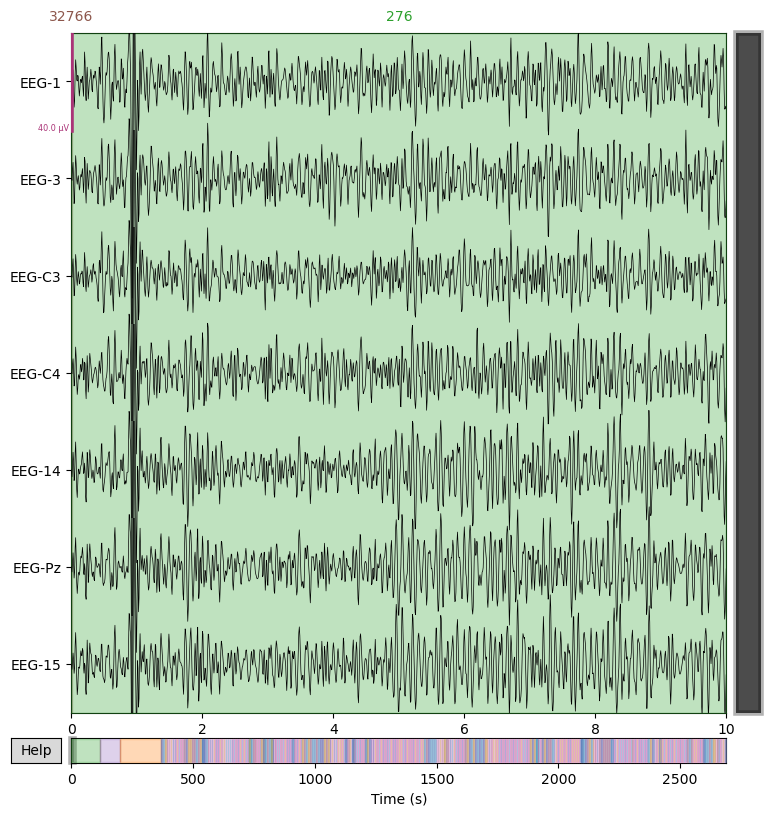

In [62]:
# plotting the subset across all necessary channels
raw_subset_8_30.plot();

In [63]:
'''
Perform ICA-fitting  and obtaining the 'bad channels'
'''
ica = mne.preprocessing.ICA(n_components=7, random_state=0)
ica.fit(raw_subset_8_30)

explained_var_ratio = ica.get_explained_variance_ratio(raw_subset_8_30)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )
for i in range(7):
    explained_var_ratio = ica.get_explained_variance_ratio(
        raw_subset_8_30, components=[i], ch_type="eeg"
    )
    # This time, print as percentage.
    ratio_percent = float(100 * explained_var_ratio["eeg"])
    print(
        f"Fraction of variance in EEG signal explained by {i} component: "
        f"{ratio_percent}%"
    )

Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components
Fitting ICA took 3.0s.
Fraction of eeg variance explained by all components: 1.0
Fraction of variance in EEG signal explained by 0 component: 0.00048317220413540696%
Fraction of variance in EEG signal explained by 1 component: 14.353960318509218%
Fraction of variance in EEG signal explained by 2 component: 22.67306384307677%
Fraction of variance in EEG signal explained by 3 component: 21.729763084985287%
Fraction of variance in EEG signal explained by 4 component: 15.447462268498946%
Fraction of variance in EEG signal explained by 5 component: 16.947887712427757%
Fraction of variance in EEG signal explained by 6 component: 8.847379616263506%


Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 1 ICA component
    Projecting back using 7 PCA components


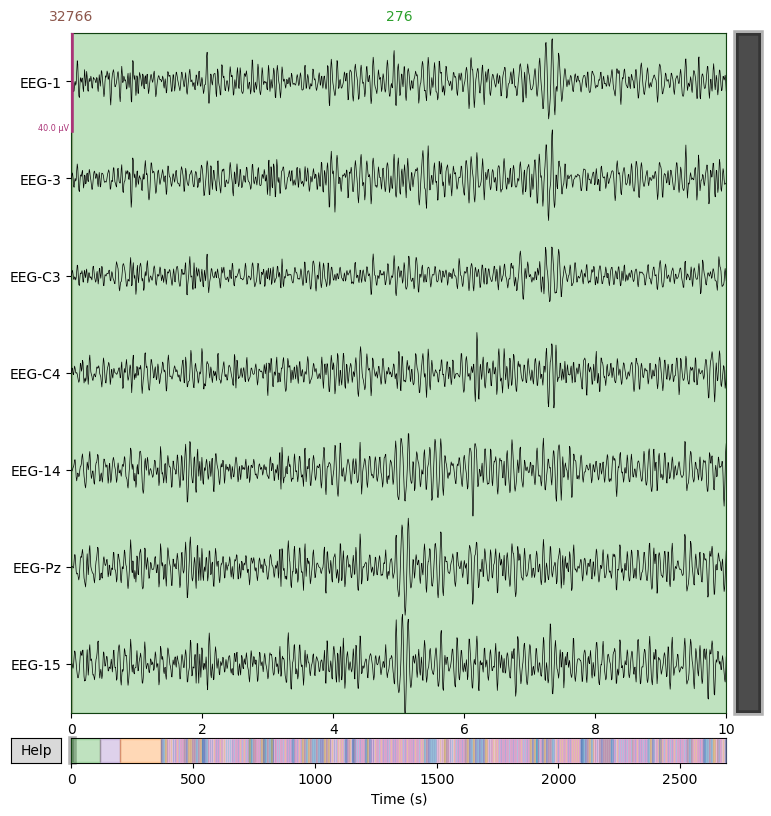

In [64]:
# bad channels are the first and last(sort of) -- based on the results above
ica.exclude = [0,-1]

# Perform ICA then plot
raw_subset_8_30_orig = raw_subset_8_30.copy()
raw_subset_8_30.load_data()
ica.apply(raw_subset_8_30)
raw_subset_8_30.plot();

In [65]:
# Check for new data shape
data_ica = raw_subset_8_30.get_data()
type(data_ica), data_ica.shape

(numpy.ndarray, (7, 672528))

In [66]:
# '''
# Run LDA ?
# '''
# import numpy as np
# from util2 import A3Load
# DIR, loc, EEG_eval, EEGL_eval, EEGR_eval, EEGL_train, EEGR_train = A3Load()

# # need to format the data for MNE, ugh
# I_PARTICIPANT = 6
# I_FILTER = 1

# N_EPOCHS = 72
# N_CHANNELS = 22

# l_train = []
# r_train = []
# for i in range(N_EPOCHS):
#     l_train.append(EEGL_train[I_PARTICIPANT][I_FILTER][:,:,i])
#     r_train.append(EEGR_train[I_PARTICIPANT][I_FILTER][:,:,i])

# X = np.array(l_train + r_train)
# X = X.astype(np.float64)

# y_l = np.zeros(len(l_train))
# y_r = np.ones(len(r_train))

# y = np.concatenate((y_l, y_r))

# X.shape, y.shape

In [69]:
epochs = mne.Epochs(raw_subset_8_30, events, event_id=ordered_event_id, event_repeated='drop', preload=True)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 176 original time points ...
1 bad epochs dropped


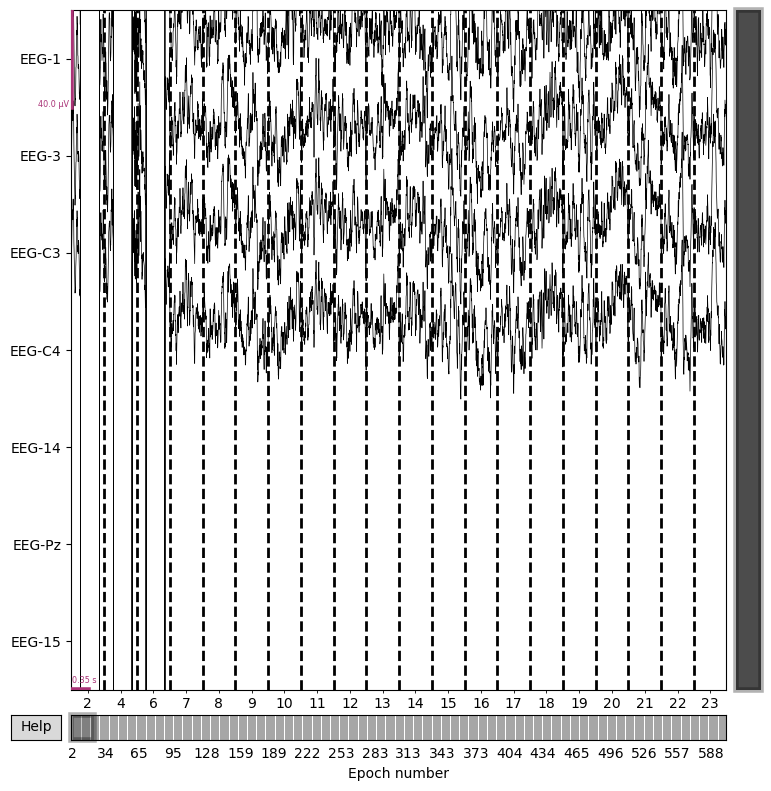

In [68]:
#epochs.plot();

In [ ]:
# viz.plot_events(events, raw_subset_8_30.info['sfreq'], raw_subset_8_30.first_samp,
#                     event_id=ordered_event_id)